In [1]:
from pyspark.sql import SparkSession 
spark = SparkSession \
    .builder \
    .appName("Python Spark Average Tempo for Decade") \
    .getOrCreate()

In [4]:
#spark.stop()

NameError: name 'spark' is not defined

In [2]:
TOPIC = 'groupB04.spotifytempos'

In [3]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "node1:9092") \
  .option("subscribe", TOPIC) \
  .option("startingOffsets","latest") \
  .option("failOnDataLoss", "false")\
  .option("checkpointLocation", "/tmp/b6") \
  .load() \
  .withWatermark("timestamp", "10 Seconds")

In [4]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
from pyspark.sql.functions import get_json_object, concat, lit
from pyspark.sql.types import *
from pyspark.sql import functions as f

#values = converted['value'].apply(lambda x: str(x)[2:-2].split(','))
split_col = f.split(df['value'], ',')
decade = concat(split_col.getItem(1)[0:3], lit('0s'))


df = df \
         .withColumn('UUID', split_col.getItem(0)) \
         .withColumn('year', split_col.getItem(1)) \
         .withColumn('tempo', split_col.getItem(2)) \
         .withColumn('decade', decade) \

converted = df \
    .selectExpr("UUID", "year", "tempo", "partition", "offset", "decade")\
    .select([\
            df["UUID"].cast(StringType()), \
            df["year"].cast(IntegerType()), \
            df["tempo"].cast(DoubleType()), \
            df["partition"].cast(IntegerType()), \
            df["offset"].cast(IntegerType()), \
            df["decade"].cast(StringType())\
            ])

In [6]:
groupdf = converted \
    .select("partition", "year", "decade", "tempo", "offset") \
    .groupby("decade") \
    .agg( \
         f.avg("tempo").alias("Average Tempo"), \
         f.count("partition").alias("count"), \
         f.max("offset").alias("offsetMax")) \
    .sort("decade")

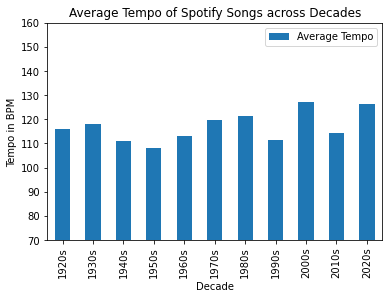

Epoch: 18


KeyboardInterrupt: 

In [7]:
%matplotlib inline
from pyspark.sql import SparkSession
from IPython import display
import matplotlib.pyplot as plt

def render_plot(epoch_frame, epoch_id):
    if (epoch_frame.count()==0):
        print("Waiting for new messages ...")
        return
    epoch_frame.toPandas().plot(kind='bar', x='decade', y='Average Tempo')
    display.clear_output(wait=True)
    plt.title("Average Tempo of Spotify Songs across Decades")
    plt.ylabel("Tempo in BPM")
    plt.xlabel("Decade")
    plt.gca().set_ylim([70,160])
    plt.show()
    #df.show()
    print("Current Epoch: " + str(epoch_id))
    

df = groupdf \
    .writeStream \
    .outputMode("complete") \
    .foreachBatch(render_plot) \
    .trigger(processingTime="5 Seconds") \
    .start() \
    .awaitTermination()

In [ ]:
spark.stop()